# Проектная работа по дисциплине анализ данных
## Электромобили  
    
    
    
  
##### Выполнили:  
Фан Хоай Линь  
Ле Тхи Тхюи Ньи  
Чан Фыонг Куе  

## Цель работы:  
В данной работе мы хотим провести анализ и моделирования данных о продаже электромобилей, с использованием машинного обучения, с целью выявления зависимостей между характеристиками автомобилей и их стоимостью

## Выполнение

## Пункт 1: Сбор данных  
Для выполнения данного проекты было принято решение собрать данные из объявлениий о прадаже электромобилей с сайта https://www.edmunds.com/. Решение было обасновано тем, что каждое объявление имело большое количество характеристик продоваемого автомобиля, что полностью удволетворяло нас.

### Создание парсера
При создании парсера были использованы библиотеки: `requests` для выполнения запросов к серверу и обработки ответов, `beautifulsoap` для извлечения данных из файлов html, `csv` для записи полученных данных из html-страницы, `tqdm` для отображения proggres bar при сборе информации и итерациях по циклам. 

In [4]:
# импорт необходимых библиотек
import csv
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# запись url-адреса в переменную url
url = 'https://www.edmunds.com/inventory/srp.html?radius=100&engineType=electric&pagenumber='

# создание словаря заголовков
headers = {
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/113.0'
}

В данных двух блоках мы импортировали все необходимые нам библиотеки, а также создали переменную `url` куда поместили адрес нашего сайта, а также словарь `headers` в котором создаем два ключа `User-Agent` и `Accept` для того, чтобы показать сайту, что наш парсер не бот, и избежать ограничения или блокировки.

In [3]:
# создание csv файла, в который запишутся названия и ссылки на электромобили
with open('cars_links.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Name', 'Link'])
    
    
    # цикл для прохода по страницам сайта
    for page in tqdm(range(1,40)):
        page_html = requests.get(f"{url}{page}", headers=headers)
        # в аргумент супа передаем полученную ссылку на сайт
        soup = BeautifulSoup(page_html.content, 'html.parser')
        for cars_cards in soup.find_all('div', {'class': 'slick-slide slick-active slick-current'}):
            link = cars_cards.find('a').get('href')
            name = cars_cards.find('a', {'class': 'usurp-inventory-card-vdp-link'}).get('aria-label')
            writer.writerow([name, 'https://www.edmunds.com' + link])

100%|███████████████████████████████████████████| 39/39 [00:52<00:00,  1.35s/it]


В данном блоке мы создали цикл для прохода по страницам сайта и сбора данных о названиях и ссылках на автомобили, которые запишутся в csv-файл `cars_links`, чтобы в дальнейшем обращаться к ссылкам из файла и лишний раз не давать повод сайту ограничить нашему парсеру доступ к нему.

In [7]:
# сооздаем файл для хранения информации об автомобилях
with open('edmunds_cars.csv', 'a', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames = [
        'Name', 'Price', 'Mileage', 'Transmission', 'Number of Owners', 'Seats', 'Standard Payload Capacity (lbs)', 'MPGe', 'Original EPA Range', 'EPA Time to Charge', 'Consumer reviews'])

    if file.tell() == 0:
        writer.writeheader()

    # открываем файл со ссылками и считываем оттуда информацию    
    with open('cars_links.csv', 'r', encoding='utf-8') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        
        # цикл перебора строк в файле со ссылками
        for row in tqdm(csv_reader):

            cars_info = []
            url = row['Link']
            car_name = row['Name']
            
            # переходим на сайт по ссылке из файла
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')

            # создаем словарь с ключами-признакми и пустыми значениями
            cars_info = {
            'Name': '',
            'Price': '',
            'Mileage': '',
            'Transmission': '',
            'Number of Owners': '',
            'Standard Payload Capacity (lbs)': '',
            'MPGe': '',
            'Original EPA Range': '',
            'EPA Time to Charge': '',
            'Consumer reviews': '',
            'Seats': ''
        }
            
            
            # присваиваем название автомобиля
            cars_info['Name'] = car_name

            
            # получаем информацию о стоимости
            price = soup.find('span', {'data-test': 'vdp-price-row'}).get_text()
            cars_info['Price'] = price

            
            # проходимся по ul списку и ищем нужные значения
            summary_lists = soup.find_all('ul', class_='mb-0 pl-0 pr-1 col-12 col-md-6')
            for summary in summary_lists:
                for li in summary.find_all('li'):
                    if li.find('div', string='Mileage'):
                        # получаем информацию о пробеге
                        cars_info['Mileage'] = li.find('div', class_='font-weight-bold').string.strip()
                    elif li.find('div', string='Transmission'):
                        # получаем информацию о трансмиссии
                        cars_info['Transmission'] = li.find('div', class_='font-weight-bold').string.strip()

            
            # ищем электрический расход
            mpge_item = soup.find('div', text='MPGe')
            if mpge_item:
                cars_info['MPGe'] = mpge_item.find_next("div").get_text().strip().split()[57].replace('gasoline.', '')
        
            # ищем информацию о количестве сидений
            seats_item = soup.find('div', text='Seats')
            cars_info['Seats'] = seats_item.find_next('div', {'class': 'pr-0 font-weight-bold text-right ml-1 col'}).contents[0]

            
            # получаем информацию о грузоподъемности
            capacity_elem = soup.find("div", text='Standard Payload Capacity')
            if capacity_elem:
                capacity = capacity_elem.find_next('div', {'class': 'pr-0 font-weight-bold text-right ml-1 col'})
                if capacity:
                    cars_info['Standard Payload Capacity (lbs)'] = (capacity.contents[0]).replace(' lbs', '')

            
            # данные о предыдущих владельцах
            ul = soup.find('ul', {'class': 'list-unstyled max-width mb-0_25 px-0 row'})
            if ul:
                lis = ul.find_all('li')
                if len(lis) > 1:
                    li = lis[1]
                    div = li.find('div', {'class': 'vehicle-history-item'})
                    if div:
                        title = div.find('h3', {'class': 'mt-0_75 mb-0_25 display-lg text-center text-gray-darker'})
                        if title:
                            if title.text.strip() == 'Owner count not available':
                                title_text = '0 Owner'
                            else:
                                title_text = title.text.strip()
                            cars_info['Number of Owners'] = title_text.split()[0]

            
            # собираем информацию о заводском объеме аккумулятора
            if soup.find('section', {'class': 'battery-range-and-charging'}) is not None:  
                range_element = soup.find('span', {'class': 'font-weight-bold'}).text.strip()
                cars_info['Original EPA Range'] = range_element
                battery_div = soup.find('section', {'class': 'battery-range-and-charging'})
            # находим данные о времени заряда
            if battery_div:
                time_div = battery_div.find('div', {'class': 'epa-time'})
                if time_div:
                    cars_info['EPA Time to Charge'] = time_div.find('span', {'class': 'font-weight-bold text-right'}).get_text()

            
            # оценка потребителя
            consumer_review_div = soup.find('div', {'class': 'consumer-review-summary d-flex flex-column d-md-block clearfix pr-md-3_5 mb-1_5'})
            if consumer_review_div:
                cars_info['Consumer reviews'] = consumer_review_div.find_next('span', {'class': 'average-user-rating d-inline-block heading-5 mr-0_25 mr-md-0_5'}).contents[0]

            
            # заполняем пропуски нулевыми значениями
            for key, value in cars_info.items():
                if not value:
                    cars_info[key] = np.nan

            # записываем полученные данные в файл 
            writer.writerow(cars_info)

609it [15:11,  1.50s/it]


Здесь мы создали сам парсер, которй собирает информацию о каждом автомобиле, т. е. проходит по всем объектам на странице. Логика была такова: собрать все названия и ссылки на автомобили, чтобы в дальнейшем собирать информацию о каждом автомобиле переходя по заранее полученной сслыке. Далее был создан список в котором будут хранится словари с инфорацией о машине, после чего этот список будет записан в файл.

##  Пункт 2: Предварительная обработка данных


In [5]:
df = pd.read_csv('edmunds_cars.csv')
df.head(10)

,Name,Price,Mileage,Transmission,Number of Owners,Seats,Standard Payload Capacity (lbs),MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews
0,2020 Kia Niro EV EX Premium,"$26,994","14,874",direct drive,1.0,5,"1,062",112.0,239 miles,9.5 hrs,4.7
1,2022 Ford E-Transit Cargo Van 350 Medium Roof,"$47,999","2,797",direct drive,0.0,2,"3,628",NaN,NaN,9.5 hrs,4.0
2,2020 MINI Hardtop 2 Door Cooper SE Hatchback,"$27,990","6,542",direct drive,1.0,4,728,108.0,110 miles,4 hrs,4.5
3,2022 Polestar 2 Long Range Dual Motor Hatchback,"$38,589","1,484",direct drive,1.0,5,NaN,89.0,249 miles,8 hrs,3.9
4,2022 Polestar 2 Long Range Dual Motor Hatchback,"$38,589","1,605",direct drive,1.0,5,NaN,89.0,249 miles,8 hrs,3.9
5,2022 Polestar 2 Long Range Dual Motor Hatchback,"$38,589","1,169",direct drive,1.0,5,NaN,89.0,249 miles,8 hrs,3.9
6,2019 Hyundai Ioniq Electric Base Hatchback,"$18,596","13,035",direct drive,1.0,5,"1,025",NaN,124 miles,4 hrs,5.0
7,2023 Ford Mustang Mach-E Premium Hatchback,"$49,499","1,955",direct drive,0.0,5,NaN,103.0,229-252 miles,8.1 hrs,4.3
8,2023 Hyundai Kona Electric Limited,"$33,500","1,564",direct drive,1.0,5,926,120.0,258 miles,9.5 hrs,3.6
9,2023 Mercedes-Benz EQS SUV EQS 450+,"$85,063","6,733",direct drive,1.0,5,NaN,85.0,305 miles,12.8 hrs,5.0


В данном блоке мы считали ифномрацию из файла `edmunds-cars.csv` и создали датафрейм

#### Форматироание данных

In [6]:
df['Price'] = df['Price'].astype(str)
df['Original EPA Range'] = df['Original EPA Range'].astype(str)
df['EPA Time to Charge'] = df['EPA Time to Charge'].astype(str)
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '').astype(float)
df['Original EPA Range'] =  df['Original EPA Range'].str.extract('(\d+)', expand=False).astype(float)
df['EPA Time to Charge'] = df['EPA Time to Charge'].str.replace(' hrs', '').astype(float)
df['Mileage'] = df['Mileage'].str.replace(',', '').astype(int)
df

,Name,Price,Mileage,Transmission,Number of Owners,Seats,Standard Payload Capacity (lbs),MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews
0,2020 Kia Niro EV EX Premium,26994.0,14874,direct drive,1.0,5,"1,062",112.0,239.0,9.5,4.7
1,2022 Ford E-Transit Cargo Van 350 Medium Roof,47999.0,2797,direct drive,0.0,2,"3,628",NaN,NaN,9.5,4.0
2,2020 MINI Hardtop 2 Door Cooper SE Hatchback,27990.0,6542,direct drive,1.0,4,728,108.0,110.0,4.0,4.5
3,2022 Polestar 2 Long Range Dual Motor Hatchback,38589.0,1484,direct drive,1.0,5,NaN,89.0,249.0,8.0,3.9
4,2022 Polestar 2 Long Range Dual Motor Hatchback,38589.0,1605,direct drive,1.0,5,NaN,89.0,249.0,8.0,3.9
...,...,...,...,...,...,...,...,...,...,...,...
825,2020 Kia Niro EV EX,29999.0,18526,direct drive,1.0,5,"1,062",112.0,239.0,9.5,4.7
826,2013 Tesla Model S Base,30590.0,58218,direct drive,3.0,5,NaN,95.0,244.0,NaN,4.5
827,2017 Tesla Model S 60D,46990.0,20901,direct drive,1.0,5,NaN,104.0,213.0,NaN,4.5
828,2014 Toyota RAV4 EV Base,19990.0,50665,direct drive,2.0,5,973,76.0,NaN,NaN,4.4


Мы отформатировали нашу выборку, удалив лишние символы: *`$`* и *`,`* у признака `Price`, а также строки с обозначением едениц измерени: *`miles`* и *`hrs`* у `Original EPA Range` и `EPA Time to Charge`. После чего мы привели данные признаки к типу данных *`float`* для удобства и точности в дальнейшем использовании

#### Анализ содержимого столбцов

| Variable      | Description                                                                                                 |
| ------------- | ----------------------------------------------------------------------------------------------------------- |
| Name            |Name of car                                                                                     |
| Price          | Price of car                                                                                        |
| Mileage         | The distance covered by the vehicle for all the time                                                                                |
| Transmission      | Refers to the automatic or manual system that transfers power from the engine to the wheels of a vehicle.                                                                                          |
| Number of Owners     | Number of people who have owned the vehicle                                                                                         |
| Seats   | Number of seats of the car                                                                                  |
| Standard Payload Capacity (lbs)      | The maximum weight that a vehicle can carry in terms of passengers and cargo                                                                                   |
| MPGe        | The distance traveled by the vehicle per unit of fuel consumed, usually expressed in miles per gallon (mpg)                                                                              |
| Original EPA Range    | Original the distance's expected to travel on a full charge                                                                     |
| EPA Time to Charge          | Time to charge from 0% to 100% ( 240v)                                                                                             |
| Consumer reviews     | average grade that other owners gave to the vehicle (max 5)                                                                |

#### Анализ пропусков, дубликатов и выбросов

In [7]:
df.shape

(830, 11)

Размер датафрейма: 830 строк 11 столбцов

##### Обработка пропусков

In [8]:
df.isnull().sum()

Name                                 0
Price                                0
Mileage                              0
Transmission                         0
Number of Owners                     2
Seats                                0
Standard Payload Capacity (lbs)    483
MPGe                               121
Original EPA Range                  82
EPA Time to Charge                 132
Consumer reviews                    14
dtype: int64

После выполнения кода мы можем увидеть что в признаке `Standard Payload Capacity (lbs)` 483 пропуска, в то время как размер нашей выборки 830, что является более 58% от всей выборки, было приянто решение удалить данный признак

In [9]:
df = df.drop('Standard Payload Capacity (lbs)', axis=1)

`MPGe`, `Original EPA Range`, `EPA Time to Charge` являются важными факторами и большая часть выборки имеет данный признак, кроме того заполнить пропущенные значения медианой или средним нельзя, так как значения параметров выборки довольно сильно разнятся, поэтому мы решили удалить все строки со значениями `NaN` у этих признаков 

In [10]:
df = df.dropna(subset=['MPGe', 'Original EPA Range', 'EPA Time to Charge'])

Для признаков `Number of Owners` и `Consumer reviews`  мы заменим их `NaN` значения на среднее по столбцу, так как количество нулевых значений крайне мало

In [11]:
df[['Number of Owners', 'Consumer reviews']]=df[['Number of Owners', 'Consumer reviews']].fillna(df[['Number of Owners', 'Consumer reviews']].mean())
df.reset_index(drop=True)

,Name,Price,Mileage,Transmission,Number of Owners,Seats,MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews
0,2020 Kia Niro EV EX Premium,26994.0,14874,direct drive,1.0,5,112.0,239.0,9.5,4.7
1,2020 MINI Hardtop 2 Door Cooper SE Hatchback,27990.0,6542,direct drive,1.0,4,108.0,110.0,4.0,4.5
2,2022 Polestar 2 Long Range Dual Motor Hatchback,38589.0,1484,direct drive,1.0,5,89.0,249.0,8.0,3.9
3,2022 Polestar 2 Long Range Dual Motor Hatchback,38589.0,1605,direct drive,1.0,5,89.0,249.0,8.0,3.9
4,2022 Polestar 2 Long Range Dual Motor Hatchback,38589.0,1169,direct drive,1.0,5,89.0,249.0,8.0,3.9
...,...,...,...,...,...,...,...,...,...,...
560,2021 Ford Mustang Mach-E Select Hatchback,39999.0,13148,direct drive,5.0,5,93.0,231.0,8.5,4.2
561,2022 Hyundai IONIQ 5 SE,42589.0,16950,direct drive,1.0,5,114.0,303.0,8.5,4.5
562,2022 Kia EV6 Wind,49998.0,20587,direct drive,1.0,5,105.0,274.0,8.4,4.3
563,2021 Ford Mustang Mach-E First Edition Hatchback,44590.0,20688,direct drive,2.0,5,90.0,271.0,10.7,4.2


Сбросим все индексы по умолчанию после форматирования выборки

##### Выведем отформатироавнный датафрейм

In [95]:
df.head(30)

,Year,Model,Price,Mileage,Transmission,Number of Owners,Seats,MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews,36 month payment
0,2020,Kia Niro EV EX Premium,26994.0,14874,direct drive,1.0,5,112.0,239.0,9.5,4.7,816.94
2,2020,MINI Hardtop 2 Door Cooper SE Hatchback,27990.0,6542,direct drive,1.0,4,108.0,110.0,4.0,4.5,847.08
3,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1484,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84
4,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1605,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84
5,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1169,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84
7,2023,Ford Mustang Mach-E Premium Hatchback,49499.0,1955,direct drive,0.0,5,103.0,229.0,8.1,4.3,1498.02
8,2023,Hyundai Kona Electric Limited,33500.0,1564,direct drive,1.0,5,120.0,258.0,9.5,3.6,1013.83
9,2023,Mercedes-Benz EQS SUV EQS 450+,85063.0,6733,direct drive,1.0,5,85.0,305.0,12.8,5.0,2574.31
11,2021,Tesla Model S Long Range,61990.0,12331,direct drive,1.0,5,120.0,384.0,15.0,3.1,1876.04
13,2023,Mercedes-Benz EQS EQS 450+,88448.0,1796,direct drive,1.0,5,97.0,350.0,12.5,3.8,2676.76


## Пункт 3:  Создание новых признаков

Для начала посмотрим какие типы данных находятся в наших столбцах, и проанализируем, какие признаки можно добавить на их основании

In [94]:
df.dtypes

Year                   object
Model                  object
Price                 float64
Mileage                 int32
Transmission           object
Number of Owners      float64
Seats                   int64
MPGe                  float64
Original EPA Range    float64
EPA Time to Charge    float64
Consumer reviews      float64
36 month payment      float64
dtype: object

Посмотрев струткру сзначений, мы заметили, что названия автомобилей всегда начинаются с года выпуска, поэтому создаем новый признак `Year` в которм будет указан год производства автомобиля

In [49]:

df[['Year', 'Model']] = df['Name'].str.split(' ',n=1, expand=True)


df.drop('Name', axis=1, inplace=True)
df['Year'].astype(int)

df.insert(0, 'Year', df.pop('Year'))
df.insert(1, 'Model', df.pop('Model'))

KeyError: 'Name'

Добавим новый признак `36 month payment`. Содержимое - сумма, которую необходимо заплатить, если покупатель хочет взять автомобиль в рассрочку на 36 месяцев с годовой процентной `APR`, которая по оценке сайта состовляет 5,65%

In [50]:
APR = 0.0565
months = 36
df['36 month payment'] = round((df['Price'] * (APR/12) * (1 + (APR/12))**months) / ((1 + (APR/12))**months - 1), 2)
df.head()

,Year,Model,Price,Mileage,Transmission,Number of Owners,Seats,MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews,36 month payment
0,2020,Kia Niro EV EX Premium,26994.0,14874,direct drive,1.0,5,112.0,239.0,9.5,4.7,816.94
2,2020,MINI Hardtop 2 Door Cooper SE Hatchback,27990.0,6542,direct drive,1.0,4,108.0,110.0,4.0,4.5,847.08
3,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1484,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84
4,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1605,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84
5,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1169,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84


In [96]:
df['New Released'] = ['1' if int(year) >= 2022 else '0' for year in df['Year']]
df['New Released'].value_counts()
df.head(30)

,Year,Model,Price,Mileage,Transmission,Number of Owners,Seats,MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews,36 month payment,New Released
0,2020,Kia Niro EV EX Premium,26994.0,14874,direct drive,1.0,5,112.0,239.0,9.5,4.7,816.94,0
2,2020,MINI Hardtop 2 Door Cooper SE Hatchback,27990.0,6542,direct drive,1.0,4,108.0,110.0,4.0,4.5,847.08,0
3,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1484,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84,1
4,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1605,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84,1
5,2022,Polestar 2 Long Range Dual Motor Hatchback,38589.0,1169,direct drive,1.0,5,89.0,249.0,8.0,3.9,1167.84,1
7,2023,Ford Mustang Mach-E Premium Hatchback,49499.0,1955,direct drive,0.0,5,103.0,229.0,8.1,4.3,1498.02,1
8,2023,Hyundai Kona Electric Limited,33500.0,1564,direct drive,1.0,5,120.0,258.0,9.5,3.6,1013.83,1
9,2023,Mercedes-Benz EQS SUV EQS 450+,85063.0,6733,direct drive,1.0,5,85.0,305.0,12.8,5.0,2574.31,1
11,2021,Tesla Model S Long Range,61990.0,12331,direct drive,1.0,5,120.0,384.0,15.0,3.1,1876.04,0
13,2023,Mercedes-Benz EQS EQS 450+,88448.0,1796,direct drive,1.0,5,97.0,350.0,12.5,3.8,2676.76,1


Здесь мы создали ноывй признак на основе года выпуска автомобиля, если значение в столбце `Year` больше или равен 2022, то такая машина считается новой, и заносится значение 1 в новый признак, 0 - в противном случае

## Пункт 4: Разведывательный анализ данных

In [120]:
df.describe()

,Price,Mileage,Number of Owners,Seats,MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews,36 month payment
count,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000
mean,43066.380531,14669.231858,1.101064,4.890265,103.918584,236.576991,9.002301,4.151718,1303.343558
std,18436.039219,12656.582356,0.397776,0.388661,14.139769,66.477478,2.409747,0.406378,557.941199
min,11990.000000,16.000000,0.000000,2.000000,68.000000,57.000000,3.000000,3.000000,362.860000
25%,28990.000000,4756.000000,1.000000,5.000000,93.000000,213.000000,8.000000,4.000000,877.340000
50%,40987.000000,10347.000000,1.000000,5.000000,108.000000,245.000000,9.300000,4.200000,1240.410000
75%,49895.000000,20422.000000,1.000000,5.000000,115.000000,276.000000,10.000000,4.400000,1510.000000
max,157999.000000,75450.000000,5.000000,5.000000,126.000000,469.000000,15.000000,5.000000,4781.620000



    Средняя стоимость автомобилей 2021 года составляет около 45 060 долларов, а максимальная стоимость составляет 85 063 долларов.
    Среднее количество владельцев машин равно 1.2.
    Средняя дальность по пробегу в милях на галлон (MPGe) составляет около 99, приблизительно равномерно распределенная с некоторой вариацией.
    Средняя стоимость автомобилей на протяжении 36 месяцев составляет 1418 долларов.
    Среднее количество отзывов потребителей составляет 1859.


In [51]:
df[['Price', 'Mileage', 'Number of Owners', 'Seats', 'MPGe', 'Original EPA Range', 'EPA Time to Charge', 'Consumer reviews', '36 month payment', 'Year']].corr()

,Price,Mileage,Number of Owners,Seats,MPGe,Original EPA Range,EPA Time to Charge,Consumer reviews,36 month payment,Year
Price,1.000000,-0.319718,-0.157800,0.216127,-0.519814,0.556047,0.615127,-0.329799,1.000000,0.350252
Mileage,-0.319718,1.000000,0.318930,0.033560,0.265809,-0.066451,0.096293,0.096733,-0.319718,-0.669446
Number of Owners,-0.157800,0.318930,1.000000,-0.147201,0.095219,-0.115307,-0.035953,0.044191,-0.157800,-0.332357
Seats,0.216127,0.033560,-0.147201,1.000000,-0.079706,0.565033,0.580511,-0.118921,0.216128,0.069635
MPGe,-0.519814,0.265809,0.095219,-0.079706,1.000000,0.041403,-0.157842,0.154288,-0.519813,-0.314949
Original EPA Range,0.556047,-0.066451,-0.115307,0.565033,0.041403,1.000000,0.807334,-0.211780,0.556048,0.142833
EPA Time to Charge,0.615127,0.096293,-0.035953,0.580511,-0.157842,0.807334,1.000000,-0.291300,0.615127,-0.023704
Consumer reviews,-0.329799,0.096733,0.044191,-0.118921,0.154288,-0.211780,-0.291300,1.000000,-0.329798,-0.241664
36 month payment,1.000000,-0.319718,-0.157800,0.216128,-0.519813,0.556048,0.615127,-0.329798,1.000000,0.350252
Year,0.350252,-0.669446,-0.332357,0.069635,-0.314949,0.142833,-0.023704,-0.241664,0.350252,1.000000


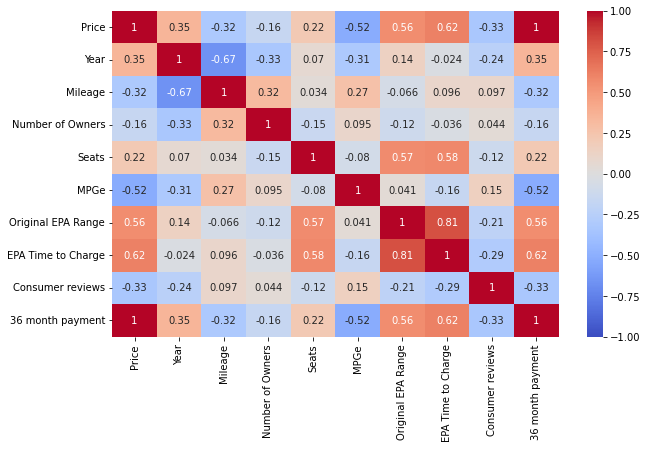

In [53]:
plt.figure(figsize=(10,6))

corr = df[['Price', 'Year', 'Mileage', 'Number of Owners', 'Seats', 'MPGe', 'Original EPA Range', 'EPA Time to Charge', 'Consumer reviews', '36 month payment']].corr()

sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True) 

plt.show()

- Цена автомобиля `Price` имеет наибольшую прямую зависимость с ежемесячным платежом в течение 36 месяцев `36 month payment`, что обусловлено расчетом стоимости ежемесячного платежа.  
- Пробег `Mileage` имеет отрицательную зависимость с ценой автомобиля `Price`, что может свидетельствовать о том, что более дорогие автомобили имеют меньший пробег, можно предположть, что на них не обыно не ездят в путешествия, либо стараются ездить только по городу.  
- Количество владельцев автомобиля `Number of Owners` имеет слабую отрицательную зависимость с ценой автомобиля `Price`.  
- `MPGe` (мили на галлон эквивалентного топлива) имеет высокую отрицательную зависимость с ценой автомобиля `Price`, что может свидетельствовать о том, что более дорогие автомобили имеют меньшую эффективность по расходу топлива.  
- Оригинальная дальность по стандарту EPA `Original EPA Range` имеет высокую прямую зависимость с ценой автомобиля `Price`, что может свидетельствовать о том, что более дорогие автомобили имеют большую дальность хода.  
- Время зарядки по стандарту EPA `EPA Time to Charge` имеет высокую прямую зависимость с ценой автомобиля `Price`, что может свидетельствовать о том, что более дорогие автомобили имеют более быструю зарядку.  
- Отзывы потребителей `Consumer reviews` имеют слабую отрицательную зависимость с ценой автомобиля `Price`, что может свидетельствовать о том, что более дорогие автомобили имеют более критичные отзывы.


In [132]:
def plot_heatmap_by_year(year):

    df_year = df[df['Year'] == year]
    corr = df_year[['Year','Price', 'Mileage', 'Number of Owners', 'Seats', 'MPGe', 'Original EPA Range', 'EPA Time to Charge', 'Consumer reviews', '36 month payment','New Released']].corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr, cmap="coolwarm", annot=True)
    plt.title(f'Correlation heatmap for {year}')
    plt.show()

In [133]:
df['Year']=df.Year.astype(int)
df.dtypes

Year                    int32
Model                  object
Price                 float64
Mileage                 int32
Transmission           object
Number of Owners      float64
Seats                   int64
MPGe                  float64
Original EPA Range    float64
EPA Time to Charge    float64
Consumer reviews      float64
36 month payment      float64
New Released           object
dtype: object

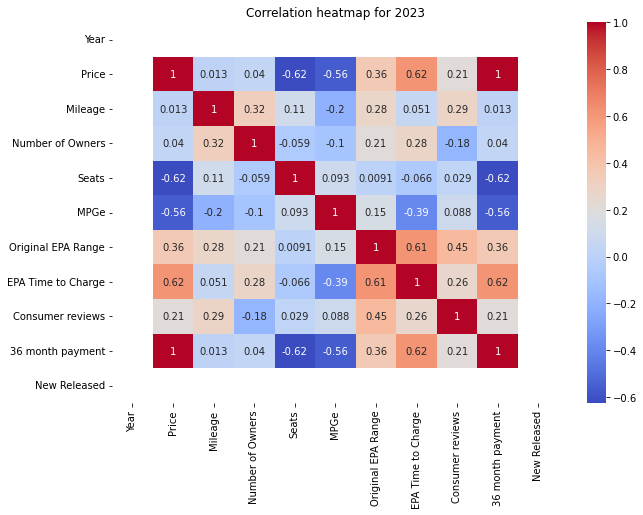

In [134]:
plot_heatmap_by_year(2023)

Разница для моделей 2023 года заключается в том, что существует отрицательная корреляция между ценой и количеством мест в автомобиле. Отзывы потребителей также более положительно коррелируют с ценой.Корреляция между ценой и пробегом моделей этого года практически отсутствует

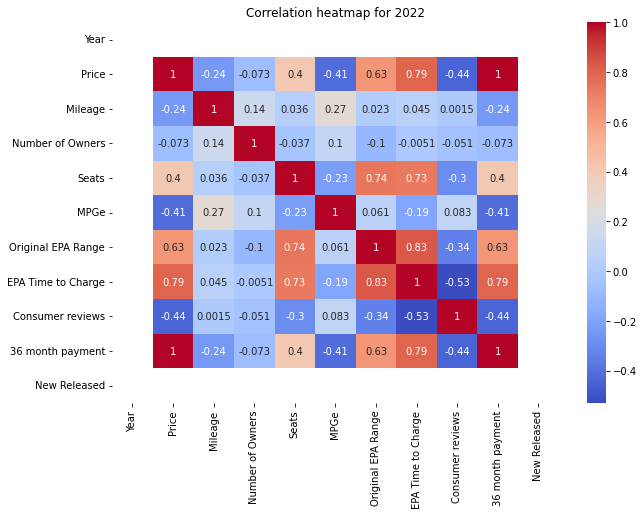

In [135]:
plot_heatmap_by_year(2022)

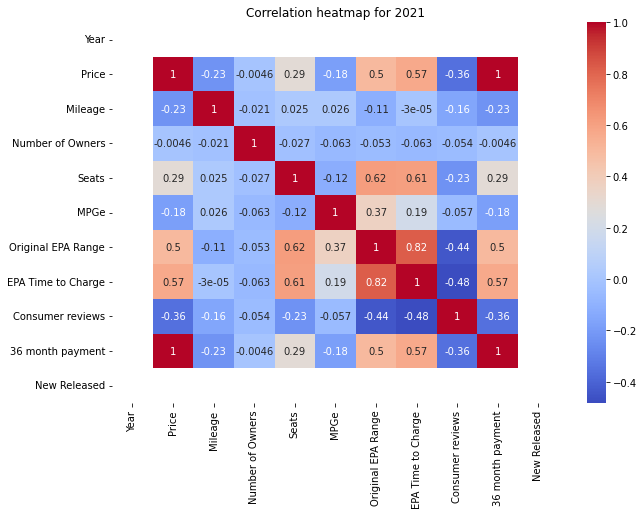

In [136]:
plot_heatmap_by_year(2021)

Цена моделей 2021 года практически не связана с количеством владельцев, которые  владели автомобилем. Количество пройденных миль также имеет слабую отрицательную зависимость с ценой

## Пункт 5: Визуализация

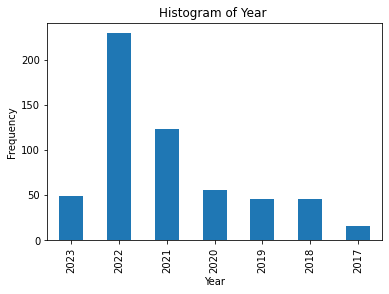

In [114]:
year_counts = df['Year'].value_counts().sort_index(ascending=False)
year_counts.plot(kind='bar')
plt.title('Histogram of Year ')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

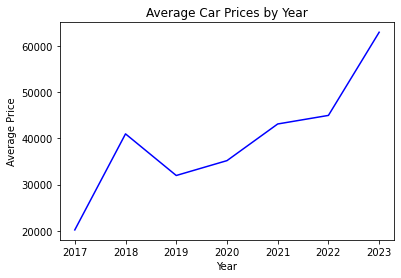

In [115]:
avg_price_by_year = df.groupby('Year')['Price'].mean()
plt.plot(avg_price_by_year.index, avg_price_by_year.values, color='blue')
plt.title('Average Car Prices by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()

Самая дорогая серийная модель 2023 года. Модель 2017 года имеет самую низкую цену

### H1. Price и Mileage
#### H1: Пробег (Mileage) имеет отрицательную зависимость с ценой автомобиля (Price) и (36 month payment)

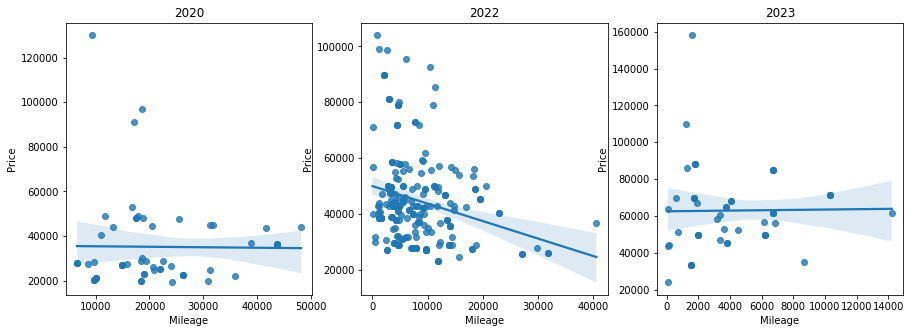

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Получаем данные только за годы 2020, 2022 и 2023
df_2020 = df[df['Year'] == 2020]
df_2022 = df[df['Year'] == 2022]
df_2023 = df[df['Year'] == 2023]

# Строим scatter plot для 2020 года с трендовой линией
sns.regplot(x='Mileage', y='Price', data=df_2020, ax=ax[0])
ax[0].set_title('2020')

# Строим scatter plot для 2022 года с трендовой линией
sns.regplot(x='Mileage', y='Price', data=df_2022, ax=ax[1])
ax[1].set_title('2022')

# Строим scatter plot для 2023 года с трендовой линией
sns.regplot(x='Mileage', y='Price', data=df_2023, ax=ax[2])
ax[2].set_title('2023')

# Выводим сетку на графики
plt.show()

In [140]:
corr_by_year = df.groupby('Year')[['Price', 'Mileage']].corr().loc[(slice(None), 'Price'), 'Mileage']
print(corr_by_year)

Year       
2017  Price    0.229088
2018  Price   -0.148448
2019  Price   -0.053413
2020  Price   -0.011461
2021  Price   -0.228497
2022  Price   -0.244136
2023  Price    0.013480
Name: Mileage, dtype: float64


Коэффициент корреляции Пирсона между пробегом и ценой составляет -0,3197, что указывает на слабую отрицательную корреляцию между двумя переменными.Также из точечной диаграммы этот результат показывает, что цена имеет тенденцию к снижению по мере увеличения пробега, но взаимосвязь не является сильной и четкой.

### H2. Price и Time to Charge
#### H2: EPA Time to Charge имеет отрицательную зависимость с ценой автомобиля (Price) и (36 month payment)

In [142]:
corr_by_year = df.groupby('Year')[['Price', 'EPA Time to Charge']].corr().loc[(slice(None), 'Price'), 'EPA Time to Charge']
print(corr_by_year)

Year       
2017  Price    0.726318
2018  Price    0.816330
2019  Price    0.745482
2020  Price    0.375232
2021  Price    0.567008
2022  Price    0.793400
2023  Price    0.618513
Name: EPA Time to Charge, dtype: float64


Можно заметить, что для большинства лет наблюдается положительная корреляция между ценой и годом выпуска. Это означает, что с увеличением года выпуска, цена на автомобиль также увеличивается.  
Лучшая корреляция наблюдается в годы 2018 и 2022 (0.816330 и 0.793400 соответственно), что говорит о том, что цены на автомобили этих годов имеют самую сильную связь с годом выпуска.

(0.0, 165299.45)

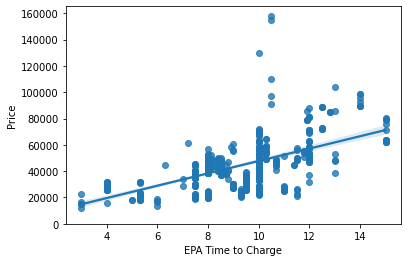

In [143]:
sns.regplot(x="EPA Time to Charge",y="Price",data=df)
plt.ylim(0,)

### H3. Price и Year
#### H3: есть зависимость между ценой и годом выпуска автомобиля

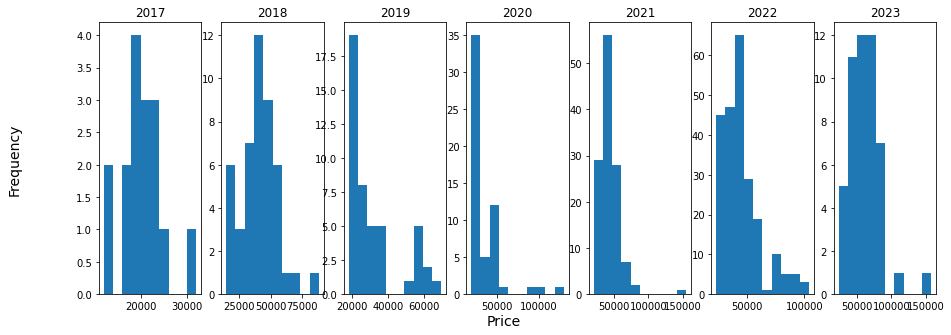

In [144]:
groups = df.groupby('Year')
fig, ax = plt.subplots(1, len(groups), figsize=(15, 5))
for i, (year, group) in enumerate(groups):
    ax[i].hist(group['Price'], bins=10)
    ax[i].set_title(str(year))    
fig.text(0.5, 0.04, 'Price', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)
plt.show()

### H4. Price и Seat
#### H4: Количество сидений (Seats) имеет слабую прямую зависимость с ценой автомобиля (Price)

In [147]:
corr_by_year = df.groupby('Year')[['Price', 'Seats']].corr().loc[(slice(None), 'Price'), 'Seats']
print(corr_by_year)

Year       
2017  Price    0.245412
2018  Price    0.495768
2019  Price         NaN
2020  Price   -0.210961
2021  Price    0.288564
2022  Price    0.403181
2023  Price   -0.624310
Name: Seats, dtype: float64


Обратим внимание на то, что для года 2019 указано значение NaN, которое означает отсутствие статистически значимой корреляции между количеством сидений и ценой.  
Для остальных лет можно отметить некоторые тенденции. Следует учитывать, что эти результаты свидетельствуют о корреляции между переменными, но не о причинно-следственной связи.  
- Для года 2023 наблюдается наиболее ярко выраженная отрицательная корреляция между количеством сидений и ценой автомобиля (коэффициент корреляции -0.624310). Это может свидетельствовать о том, что автомобили, имеющие большое количество сидений, могут быть менее востребованы на рынке.
- Для года 2017 наблюдается низкая, но положительная корреляция между количеством сидений и ценой автомобиля (коэффициент корреляции 0.245412).
- Для года 2018, 2021 и 2022 также наблюдается положительная корреляция между количеством сидений и ценой автомобиля, но уже более сильная, чем для года 2017 (коэффициент корреляции 0.495768, 0.288564 и 0.403181 соответственно).
- Для года 2020 наблюдается отрицательная корреляция между количеством сидений и ценой автомобиля (коэффициент корреляции -0.210961), что говорит о том, что автомобили, имеющие меньшее количество сидений, могут быть более востребованы из-за их компактности.

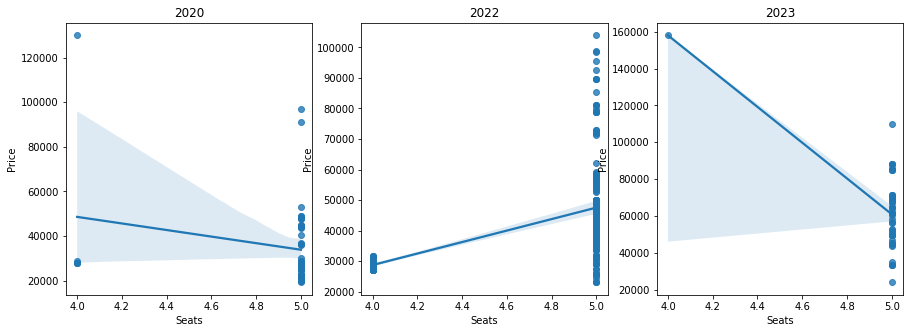

In [146]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.regplot(x='Seats', y='Price', data=df_2020, ax=ax[0])
ax[0].set_title('2020')
sns.regplot(x='Seats', y='Price', data=df_2022, ax=ax[1])
ax[1].set_title('2022')
sns.regplot(x='Seats', y='Price', data=df_2023, ax=ax[2])
ax[2].set_title('2023')
plt.show()

### H5. Price и Consumer review
#### H5: Отзывы потребителей (Consumer reviews) имеют слабую отрицательную зависимость с ценой автомобиля (Price)

In [150]:
corr_by_year = df.groupby('Year')[['Price', 'Consumer reviews']].corr().loc[(slice(None), 'Price'), 'Consumer reviews']
print(corr_by_year)

Year       
2017  Price    0.465025
2018  Price   -0.236456
2019  Price   -0.364327
2020  Price   -0.587342
2021  Price   -0.356193
2022  Price   -0.443103
2023  Price    0.209701
Name: Consumer reviews, dtype: float64


Можно заметить, что в период с 2017 по 2023 годы наблюдается слабая отрицательная корреляция между ценой автомобиля и отзывами потребителей. В свою очередь, это означает, что более дорогие автомобили, как правило, не всегда пользуются повышенным интересом со стороны потребителей.

Это может быть связано с тем, что более дешевые автомобили нацелены на широкий спектр потребителей, который может включать как первичных покупателей, так и тех, кто более осторожен и не хочет слишком рисковать. В то же время, более дорогие автомобили, как правило, нацелены на более узкую аудиторию, в которую входят более состоятельные и требовательные покупатели, что может сказаться на уровне интереса к этим моделям.

(0.0, 165299.45)

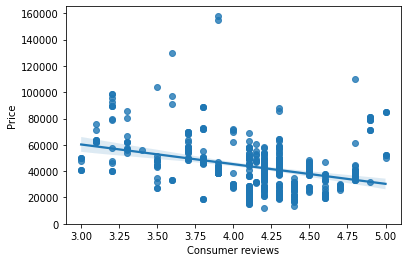

In [149]:
sns.regplot(x="Consumer reviews",y="Price",data=df)
plt.ylim(0,)

## Пункт 6: Машинное обучение

В данном пункте была выбрана задача регресии, поэтому импортируем из библиотеки `sklearn` *`LinearRegression`* для построения необходимой нам модели

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

В качестве целевой переменной был выбран признак `Price`, а в качестве признаков для обучения следующий параметры, которые могут повлиять на формирование цены:
- `Mileage`
- `Year`
- `Number of Owners`
- `MPGe`

In [63]:
# определение признаков и целевой переменной
features = ['Mileage', 'Year', 'Number of Owners', 'MPGe']
target = ['Price']

In [78]:
# создание набора данных для обучения модели
X = df[features]
y = df[target]

In [86]:
# добиваемся воспроизводимости результатов
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### Обучение модели и предсказание результатов

In [87]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [88]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

Произведем оценку качества предсказаний с помощью `MSE` `MAE`

In [92]:
print("MSE  train %f" % mean_squared_error(y_train, pred_train))
print("MSE  test %f" % mean_squared_error(y_test, pred_test))
print("MAE  train %f" % mean_absolute_error(y_train, pred_train))
print("MAE  test %f" % mean_absolute_error(y_test, pred_test))

MSE  train 232637095.135080
MSE  test 234389018.684363
MAE  train 11265.321442
MAE  test 11393.001033


В целом, эти значения говорят о том, что у модели есть некоторая ошибка, но она не является слишком большой, поэтому попробуем уменьшить эту ошибку

### Улучшение результатов

Попробуем улучшить наши результаты за счет использования моделей `Ridge` и `Lasso`, которые могут повлиять на нашу целевую переменную.

In [105]:
# создание модели Ridge
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)
pred_train_ridge = ridge.predict(X_train)
pred_test_ridge = ridge.predict(X_test)

# создание модели Lasso
lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)
pred_train_lasso = lasso.predict(X_train)
pred_test_lasso = lasso.predict(X_test)

# оценка моделей
print("Ridge MSE train: {}".format(mean_squared_error(y_train, pred_train_ridge)))
print("Ridge MSE test: {}".format(mean_squared_error(y_test, pred_test_ridge)))
print("Lasso MSE train: {}".format(mean_squared_error(y_train, pred_train_lasso)))
print("Lasso MSE test: {}".format(mean_squared_error(y_test, pred_test_lasso)))

Ridge MSE train: 232637096.91553515
Ridge MSE test: 234391362.31185353
Lasso MSE train: 232637097.70242906
Lasso MSE test: 234382096.58268675


Похоже, что значения `MSE` на тренировочной и тестовой выборке незначительно увеличились при использовании `Ridge` и `Lasso` регрессии. Однако, разница между `MSE` на тренировочной и тестовой выборке для `Ridge` регрессии немного уменьшилась, что может говорить об улучшении обобщающей способности модели.

Попробуем добавить полиномиальные признаки степени 1 (т.е. просто копируем исходные признаки в матрицу полиномиальных признаков) и обучаем модель линейной регрессии на этих данных. В результате должны получить более простую и менее склонную к переобучению модель, которая может работать лучше на тестовых данных.

In [110]:
# добавление полиномиальных признаков
poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X)

# добиваемся воспроизводимости результатов
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

# обучение модели
lr = LinearRegression()
lr.fit(X_train, y_train)

# предсказание на тренировочной и тестовой выборках
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

# вывод метрик качества модели
print("MSE train %f" % mean_squared_error(y_train, pred_train))
print("MSE test %f" % mean_squared_error(y_test, pred_test))
print("MAE train %f" % mean_absolute_error(y_train, pred_train))
print("MAE test %f" % mean_absolute_error(y_test, pred_test))

MSE train 232637095.135080
MSE test 234389018.684363
MAE train 11265.321442
MAE test 11393.001033


После использования полиномиальных признаков, значения `MSE` и `MAE` на тренировочной и тестовой выборках по-прежнему высокие, однако ничем не отличаются от нашего первого обучения. Это может быть связано с тем, что целевая переменная зависит от признаков нелинейным образом или в данных есть шум и выбросы.

Для улучшения качества модели попробуем использовать другой тип регрессии, такой как градиентный бустинг `GradientBoostingRegressor`.

In [113]:
# добиваемся воспроизводимости результатов
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# обучение модели
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
gbr.fit(X_train, y_train.values.ravel())

# предсказание на тренировочной и тестовой выборках
pred_train = gbr.predict(X_train)
pred_test = gbr.predict(X_test)

# вывод метрик качества модели
print("MSE train %f" % mean_squared_error(y_train, pred_train))
print("MSE test %f" % mean_squared_error(y_test, pred_test))
print("MAE train %f" % mean_absolute_error(y_train, pred_train))
print("MAE test %f" % mean_absolute_error(y_test, pred_test))

MSE train 35303738.628350
MSE test 133636684.685091
MAE train 4315.058122
MAE test 6839.782878


Судя по значению `MSE` и `MAE` на тренировочной и тестовой выборках, модель с градиентным бустингом имеет более низкую ошибку, чем модель с полиномиальными признаками. Это может быть связано с тем, что градиентный бустинг может лучше обработать нелинейные зависимости между признаками и целевой переменной. Однако, значение ошибки на тестовой выборке все еще довольно высоко, что может указывать на переобучение модели.